<form action="https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Landau Energy - Multidimensional X-data Example
Author(s): Paul Miles | Date Created: February 15, 2019

This example demonstrates using [pymcmcstat](https://github.com/prmiles/pymcmcstat/wiki) with multidimensional input spaces, e.g. functions that depend on two-spatial variables such as $x_1$ and $x_2$.  For this particular problem we consider a 6th order Landau energy function, which is used in a wide variety of material science applications.  

Consider the 6th order Landau function:

$$ u(q;{\bf P}) = \alpha_{1}(P_1^2+P_2^2+P_3^2) + \alpha_{11}(P_1^2 + P_2^2 + P_3^2)^2 + \alpha_{111}(P_1^6 + P_2^6 + P_3^6) + \alpha_{12}(P_1^2P_2^2 + P_1^2P_3^2 + P_2^2P_3^2) + \alpha_{112}(P_1^4(P_2^2 + P_3^2) + P_2^4(P_1^2 + P_3^2) + P_3^4(P_1^2 + P_2^2)) + \alpha_{123}P_1^2P_2^2P_3^2$$

where $q = [\alpha_{1},\alpha_{11},\alpha_{111},\alpha_{12},\alpha_{112},\alpha_{123}]$. The Landau energy is a function of 3-dimensional polarization space.  For the purpose of this example, we consider the case where $P_1 = 0$.

Often times we are interested in using information calculated from Density Functional Theory (DFT) calculations in order to inform our continuum approximations, such as our Landau function.  For this example, we will assume we have a set of energy calculations corresponding to different values of $P_2$ and $P_3$ which were found using DFT. For more details regarding this type of research, the reader is referred to:

- Miles, P. R., Leon, L. S., Smith, R. C., Oates, W. S. (2018). Analysis of a Multi-Axial Quantum Informed Ferroelectric Continuum Model: Part 1—Uncertainty Quantification. Journal of Intelligent Material Systems and Structures, 29(13), 2823-2839. https://doi.org/10.1177/1045389X18781023
- Leon, L. S., Smith, R. C., Oates, W. S., Miles, P. R. (2018). Analysis of a Multi-Axial Quantum Informed Ferroelectric Continuum Model: Part 2—Sensitivity Analysis. Journal of Intelligent Material Systems and Structures, 29(13), 2840-2860. https://doi.org/10.1177/1045389X18781024

In [2]:
# import required packages
import numpy as np
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import mcmcplot.mcmatplot as mcmpl
import mcmcplot.mcseaborn as mcsbn
import scipy.io as sio

Define the Landau energy function.

In [3]:
def landau_energy(q, P):
    a1, a11, a111, a12, a112, a123 = q
    u = a1*((P**2).sum(axis = 1)) + a11*((P**2).sum(axis = 1))**2 + a111*((P**6).sum(axis = 1))
    u += a12*(P[:,0]**2*P[:,1]**2 + P[:,0]**2*P[:,2]**2 + P[:,1]**2*P[:,2]**2)
    u += a112*(P[:,0]**4*(P[:,1]**2 + P[:,2]**2) + P[:,1]**4*(P[:,0]**2 + P[:,2]**2) + P[:,2]**4*(P[:,0]**2 + P[:,1]**2))
    u += a123*P[:,0]**2*P[:,1]**2*P[:,2]**2
    return u

We can generate a grid in the $P_2-P_3$ space in order to visualize the model response.  The model is evaluated at a particular set of parameter values, and the surface plot shows the general behavior of the energy function.

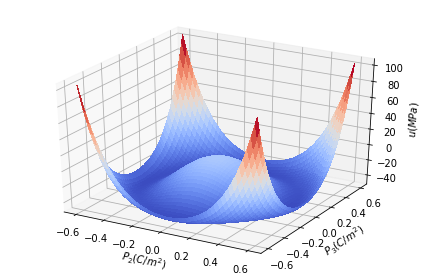

In [4]:
# Make data.
P2 = np.linspace(-0.6, 0.6, 100) #np.arange(-0.6, 0.6, 0.25)
P3 = np.linspace(-0.6, 0.6, 100) #np.arange(-0.6, 0.6, 0.25)
P2, P3 = np.meshgrid(P2, P3)
nr, nc = P2.shape
P = np.concatenate((np.zeros([nr*nc,1]), P2.flatten().reshape(nr*nc,1), P3.flatten().reshape(nr*nc,1)), axis = 1)
q = [-389.4, 761.3, 61.46, 414.1, -740.8, 0.]
Z = landau_energy(q, P)

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(P2, P3, Z.reshape([nr,nc]), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.xlabel('$P_2 (C/m^2)$')
plt.ylabel('$P_3 (C/m^2)$')
ax.set_zlabel('$u (MPa)$')
plt.tight_layout()

# DFT Data
We define a set of energy results based on a series of DFT calculations which correspond to specific polarization values.

In [6]:
pdata = sio.loadmat('dft_polarization.mat')
polarization = []
for ii, pp in enumerate(pdata['polarization']):
    polarization.append(np.zeros([pp[0].shape[0], 3]))
    polarization[-1][:,1:] = pp[0]
    if ii == 0:
        polarization_array = polarization[-1]
    else:
        polarization_array = np.concatenate((polarization_array, polarization[-1]), axis = 0)
            

edata = sio.loadmat('dft_energy.mat')
energy = []
for ii, ee in enumerate(edata['energy']):
    energy.append(np.zeros([ee[0].shape[0],1]))
    energy[-1][:,:] = ee[0]*1e3 # scale to MPa
    if ii == 0:
        energy_array = energy[-1]
    else:
        energy_array = np.concatenate((energy_array, energy[-1]), axis = 0)

dft = dict(energy = energy, polarization = polarization)

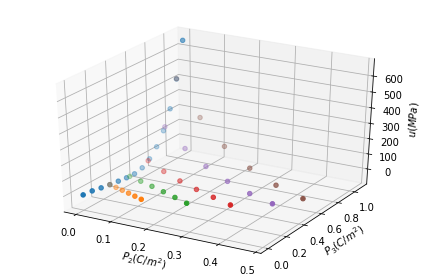

In [7]:
# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')
for ii, (pp, ee) in enumerate(zip(dft['polarization'], dft['energy'])):
    ax.scatter(pp[:,1], pp[:,2], ee)
plt.xlabel('$P_2 (C/m^2)$')
plt.ylabel('$P_3 (C/m^2)$')
ax.set_zlabel('$u (MPa)$')
plt.tight_layout()

# MCMC Simulation
First we define our sum-of-squares function

In [8]:
def ssfun(q, data):
    P = data.xdata[0]
    ud = data.ydata[0]
    um = landau_energy(q, P)
    ss = ((ud - um.reshape(ud.shape))**2).sum()
    return ss

## Initialize MCMC Object
We then initialize the MCMC object and define the components:

- data structure
- parameters
- simulation options
- model settings

In [9]:
# Initialize MCMC object
mcstat = MCMC()
# setup data structure for dram
mcstat.data.add_data_set(
    x = polarization_array,
    y = energy_array,
)
# setup model parameters
mcstat.parameters.add_model_parameter(
    name = '$\\alpha_{1}$',
    theta0 = q[0],
    minimum = -1e8,
    maximum = 1e8,
)
mcstat.parameters.add_model_parameter(
    name = '$\\alpha_{11}$',
    theta0 = q[1],
    minimum = -1e8,
    maximum = 1e8,
)
mcstat.parameters.add_model_parameter(
    name='$\\alpha_{111}$',
    theta0=q[2],
    minimum=-1e8,
    maximum=1e8
)
mcstat.parameters.add_model_parameter(
    name='$\\alpha_{12}$',
    theta0=q[3],
    minimum=-1e8,
    maximum=1e8
)
mcstat.parameters.add_model_parameter(
    name='$\\alpha_{112}$',
    theta0=q[4],
    minimum=-1e8,
    maximum=1e8
)
mcstat.parameters.add_model_parameter(
    name='$\\alpha_{123}$',
    theta0=q[5],
    sample=False, # do not sample this parameter
)

# define simulation options
mcstat.simulation_options.define_simulation_options(
    nsimu=int(5e5),
    updatesigma=True,
    method='dram',
    adaptint=100,
    verbosity=1,
    waitbar=1,
    save_to_json=False,
    save_to_bin=False,
)

# define model settings
mcstat.model_settings.define_model_settings(
    sos_function=ssfun,
    N0 = 1,
    N = polarization_array.shape[0],
)

## Run MCMC Simulation & Display Stats

In [10]:
# Run mcmcrun
mcstat.run_simulation()

results = mcstat.simulation_results.results
# specify burnin period
burnin = int(results['nsimu']/2)
# display chain statistics
chain = results['chain']
s2chain = results['s2chain']
sschain = results['sschain']
names = results['names']
mcstat.chainstats(chain[burnin:,:], results)
print('Acceptance rate: {:6.4}%'.format(100*(1 - results['total_rejected'])))
print('Model Evaluations: {}'.format(results['nsimu'] - results['iacce'][0] + results['nsimu']))


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
$\alpha_{1}$:   -389.40 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
$\alpha_{11}$:    761.30 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
$\alpha_{111}$:     61.46 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
$\alpha_{12}$:    414.10 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
$\alpha_{112}$:   -740.80 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 500000 of 500000 complete in 203.7 sec
---------------------
name      :       mean        std     MC_err        tau     geweke
$\alpha_{1}$:  -389.7189    10.3126     0.0655    15.3868     0.9993
$\alpha_{11}$:   762.3086    29.3550     0.1881    15.4770     0.9987
$\alpha_{111}$:    60.7729    19.5034     0.1275    15.4633     0.9901
$\alpha_{12}$:   421.1136   233.7327     1.4277    15.2580     0.9925
$\alpha_{112}$:  -758.5364   481.1972     2.8536    15.4057     0.9866
---------------------
Acce

## Plot MCMC Diagnostics

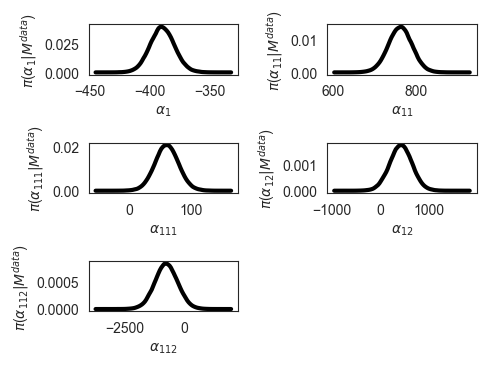

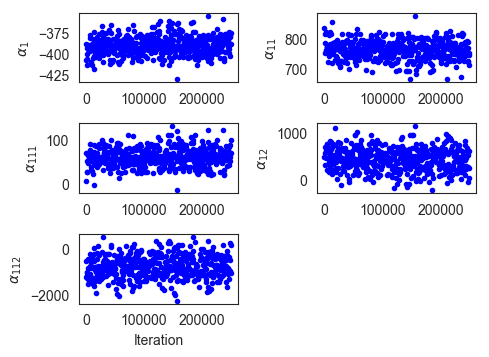

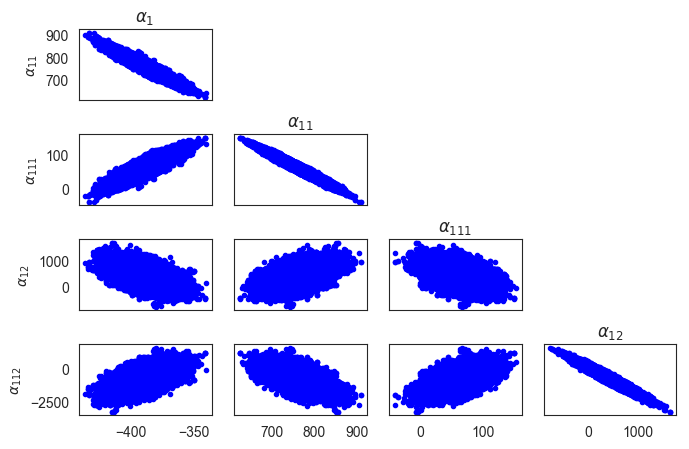

In [11]:
# generate mcmc plots
sns.set_style('white')
mcmpl.plot_density_panel(chain[burnin:,:], names); # last argument turns hist on/off
mcmpl.plot_chain_panel(chain[burnin:,:], names);
mcmpl.plot_pairwise_correlation_panel(chain[burnin:,:], names);
plt.savefig('landau_pwc.png', format='png', dpi=500, bbox_inches='tight')

# Generate and Plot Credible/Prediction Intervals

In [12]:
import pymcmcstat.settings.DataStructure as DS

def predmodelfun(data, q):
    P = data.user_defined_object[0]
    um = landau_energy(q, P)
    return um

preddata = DS.DataStructure()
for ii, (pp, ee) in enumerate(zip(dft['polarization'],dft['energy'])):
    preddata.add_data_set(
        x=np.linalg.norm(pp, axis=1),
        y=ee,
        user_defined_object=pp,
    )

mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=preddata,
    modelfunction=predmodelfun)
mcstat.PI.generate_prediction_intervals(
    nsample=500,
    calc_pred_int='on',
    waitbar=True)

Generating credible/prediction intervals:

 [-----------------100%-----------------] 500 of 500 complete in 0.3 sec
Interval generation complete



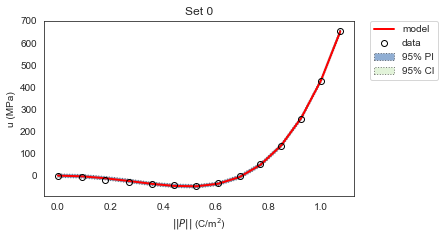

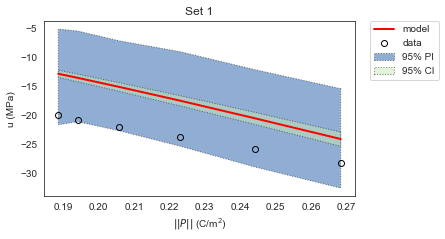

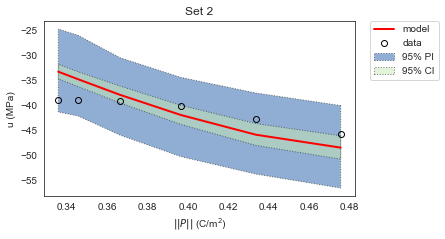

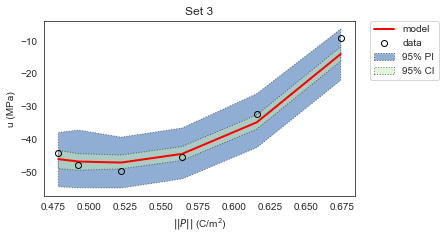

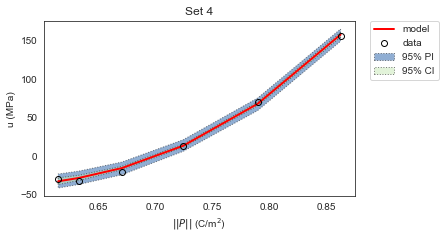

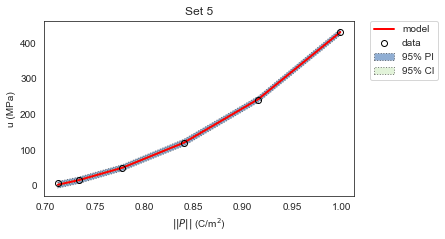

In [14]:
fighandle, axhandle = mcstat.PI.plot_prediction_intervals(
    adddata=False,
    addlegend=False,
    figsizeinches=[5, 3])
for ii in range(len(preddata.xdata)):
    axhandle[ii].plot(preddata.xdata[ii],
                      preddata.ydata[ii],
                      'ko',
                      mfc='none',
                      label = 'data')
    axhandle[ii].set_ylabel('u (MPa)')
    axhandle[ii].set_xlabel('$||P||$ (C/m$^2$)')
    axhandle[ii].set_title(str('Set {}'.format(ii)))
    axhandle[ii].legend(bbox_to_anchor=(1.05, 1),
                        loc=2, borderaxespad=0.)